In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import warnings
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, RobustScaler
import os
from dotenv import load_dotenv

# Evidently imports (v0.7.16)
from evidently import Report, Regression, DataDefinition, Dataset
from evidently.presets import DataDriftPreset, RegressionPreset
from evidently.ui.workspace import CloudWorkspace
from evidently.core.report import Snapshot

warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## Configuration and Setup

Load environment variables and configure paths to models and data.

In [6]:
# Load environment variables
load_dotenv()
evidently_token = os.getenv("EVIDENTLY_API_TOKEN")
project_id = os.getenv("PROJECT_ID")
gcs_bucket = os.getenv("GCS_BUCKET_NAME", "your-project-trading-card-game-models")

# Local paths
MODELS_DIR = Path("../airflow3-quickstart/dags/models")
DATA_DIR = Path("../airflow3-quickstart/dags/data")
TRAINING_DATA = DATA_DIR / "all_cards_master_data_training.csv"
WEEKPASS_DATA = DATA_DIR / "all_cards_master_data_weekpass.csv"

# Target variables
TARGET_VARIABLES = ['priceChange24hr', '7d_priceChange', 'price', '7d_stddevPopPrice']

print(f"Models directory: {MODELS_DIR}")
print(f"Training data: {TRAINING_DATA}")
print(f"Weekpass data: {WEEKPASS_DATA}")
print(f"Target variables: {TARGET_VARIABLES}")

Models directory: ../airflow3-quickstart/dags/models
Training data: ../airflow3-quickstart/dags/data/all_cards_master_data_training.csv
Weekpass data: ../airflow3-quickstart/dags/data/all_cards_master_data_weekpass.csv
Target variables: ['priceChange24hr', '7d_priceChange', 'price', '7d_stddevPopPrice']


In [7]:
print(evidently_token)

sk_prod.019afbbd-8b51-70cf-93c1-56e575442ab0.NjHkMKNGmBZeQNJwNXOowrB9J2jM4H8Zwu5_S5ed9R0XcljR_qeTHz3tIvNkRKF3Uq8wxUuIUdkADOECXxIU8dQEWUCagVpivNdV_0XQyKv22O5vjvji2H2uuBtTQ0R-


## Connect to Evidently Cloud (Optional)

Connect to Evidently Cloud for advanced monitoring and drift detection.

In [ ]:
# Connect to Evidently Cloud (optional - comment out if not using)
try:
    if evidently_token and project_id:
        ws = CloudWorkspace(
            token=evidently_token,
            url="https://app.evidently.cloud"
        )
        project = ws.get_project(project_id)
        print(f"Connected to Evidently Cloud")
        print(f"   Project: {project.name if hasattr(project, 'name') else project_id}")
        use_evidently = True
    else:
        print("Evidently credentials not found in .env file")
        print("   Skipping Evidently Cloud integration")
        use_evidently = False
except Exception as e:
    print(f"Failed to connect to Evidently Cloud: {e}")
    print("   Continuing without Evidently integration")
    use_evidently = False

Failed to connect to Evidently Cloud: Internal Server Error
   Continuing without Evidently integration


: 

## Load Data

Load both training and weekpass test datasets.

In [9]:
# Load datasets
print("Loading datasets...")
df_training = pd.read_csv(TRAINING_DATA)
df_weekpass = pd.read_csv(WEEKPASS_DATA)

print(f"\nTraining Data:")
print(f"  Shape: {df_training.shape}")
print(f"  Columns: {df_training.columns.tolist()[:10]}...")

print(f"\nWeekpass Data:")
print(f"  Shape: {df_weekpass.shape}")
print(f"  Columns: {df_weekpass.columns.tolist()[:10]}...")

# Display basic statistics
print("\n" + "="*60)
print("TARGET VARIABLE STATISTICS")
print("="*60)

for target in TARGET_VARIABLES:
    if target in df_training.columns:
        print(f"\n{target}:")
        print(f"  Training - Mean: {df_training[target].mean():.2f}, Std: {df_training[target].std():.2f}, Missing: {df_training[target].isna().sum()}")
        print(f"  Weekpass - Mean: {df_weekpass[target].mean():.2f}, Std: {df_weekpass[target].std():.2f}, Missing: {df_weekpass[target].isna().sum()}")

Loading datasets...

Training Data:
  Shape: (48134, 62)
  Columns: ['game', 'set_name', 'card_id', 'card_name', 'number', 'rarity', 'set', 'set_name_api', 'tcgplayerId', 'details']...

Weekpass Data:
  Shape: (48847, 62)
  Columns: ['game', 'set_name', 'card_id', 'card_name', 'number', 'rarity', 'set', 'set_name_api', 'tcgplayerId', 'details']...

TARGET VARIABLE STATISTICS

priceChange24hr:
  Training - Mean: -0.01, Std: 4.00, Missing: 4972
  Weekpass - Mean: 0.10, Std: 5.77, Missing: 5087

7d_priceChange:
  Training - Mean: -0.49, Std: 13.39, Missing: 4708
  Weekpass - Mean: 0.19, Std: 28.46, Missing: 4907

price:
  Training - Mean: 23.43, Std: 272.92, Missing: 0
  Weekpass - Mean: 23.42, Std: 273.87, Missing: 0

7d_stddevPopPrice:
  Training - Mean: 0.20, Std: 7.93, Missing: 4708
  Weekpass - Mean: 0.33, Std: 8.63, Missing: 4907

Training Data:
  Shape: (48134, 62)
  Columns: ['game', 'set_name', 'card_id', 'card_name', 'number', 'rarity', 'set', 'set_name_api', 'tcgplayerId', 'det

## Helper Functions

Define functions for feature preparation and model evaluation (same as pipeline).

In [11]:
def prepare_features(df, target_column):
    """
    Prepare features for modeling (same logic as training pipeline)
    """
    # Create a copy
    df_model = df.copy()
    
    # Drop rows where target is missing
    df_model = df_model[df_model[target_column].notna()].copy()
    
    # Select numeric features
    numeric_cols = df_model.select_dtypes(include=[np.number]).columns.tolist()
    
    # Exclude target variables and ID columns
    exclude_cols = ['priceChange24hr', '7d_priceChange', 'price', '7d_stddevPopPrice',
                    'tcgplayerId', 'tcgplayerSkuId', 'lastUpdated']
    
    numeric_features = [col for col in numeric_cols if col not in exclude_cols]
    
    # Remove problematic columns
    cols_to_remove = []
    for col in numeric_features:
        if df_model[col].isna().all():
            cols_to_remove.append(col)
        elif (df_model[col].fillna(0) == 0).all():
            cols_to_remove.append(col)
        elif df_model[col].nunique() == 1:
            cols_to_remove.append(col)
    
    numeric_features = [col for col in numeric_features if col not in cols_to_remove]
    
    # Remove highly sparse columns (>95% missing)
    for col in numeric_features.copy():
        missing_ratio = df_model[col].isna().sum() / len(df_model)
        if missing_ratio > 0.95:
            numeric_features.remove(col)
    
    # Handle missing values
    for col in numeric_features:
        if df_model[col].isna().any():
            df_model[col].fillna(df_model[col].median(), inplace=True)
    
    # Encode categorical features
    categorical_features = ['game', 'rarity', 'condition', 'printing', 'language']
    label_encoders = {}
    
    for col in categorical_features:
        if col in df_model.columns:
            df_model[col].fillna('Unknown', inplace=True)
            le = LabelEncoder()
            df_model[col + '_encoded'] = le.fit_transform(df_model[col].astype(str))
            label_encoders[col] = le
            numeric_features.append(col + '_encoded')
    
    # Remove outliers using IQR method
    Q1 = df_model[target_column].quantile(0.01)
    Q3 = df_model[target_column].quantile(0.99)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    df_model = df_model[(df_model[target_column] >= lower_bound) & 
                        (df_model[target_column] <= upper_bound)]
    
    # Prepare feature matrix and target
    X = df_model[numeric_features]
    y = df_model[target_column]
    
    return X, y, numeric_features, label_encoders


def evaluate_model(model, scaler, features, X, y, model_type='xgboost'):
    """
    Evaluate model on given data
    """
    # Ensure same feature set
    missing_features = [f for f in features if f not in X.columns]
    if missing_features:
        for feat in missing_features:
            X[feat] = 0
    
    # Select only the features used during training
    X_eval = X[features].copy()
    
    # Scale features
    X_scaled = scaler.transform(X_eval)
    
    # Predict
    if model_type == 'ridge':
        y_pred = model.predict(X_scaled)
    else:
        y_pred = model.predict(X_eval)
    
    # Calculate metrics
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    
    # Calculate additional metrics
    mape = np.mean(np.abs((y - y_pred) / y)) * 100 if (y != 0).all() else np.nan
    
    return {
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'y_true': y,
        'y_pred': y_pred,
        'samples': len(y)
    }

print("Helper functions defined")

Helper functions defined


## Load Trained Models

Load all trained models, scalers, and feature lists from the models directory.

In [13]:
# Find and load all trained models
models_data = {}

print("Loading trained models...")
print("="*60)

for target in TARGET_VARIABLES:
    print(f"\n{target}:")
    
    # Find model files for this target (could be any model type)
    model_files = list(MODELS_DIR.glob(f"model_{target}_*.pkl"))
    
    if not model_files:
        print(f"No model found")
        continue
    
    # Get the first model file and extract model type
    model_file = model_files[0]
    model_type = model_file.stem.split('_')[-1]  # e.g., 'xgboost', 'ridge', etc.
    
    print(f"  Model type: {model_type}")
    
    if model_type == 'boosting':
        model_type = 'gradient_boosting'
    
    try:
        # Load model artifacts
        model = joblib.load(MODELS_DIR / f"model_{target}_{model_type}.pkl")
        scaler = joblib.load(MODELS_DIR / f"scaler_{target}_{model_type}.pkl")
        features = joblib.load(MODELS_DIR / f"features_{target}_{model_type}.pkl")
        
        models_data[target] = {
            'model': model,
            'scaler': scaler,
            'features': features,
            'model_type': model_type
        }
        
        print(f" Loaded successfully")
        print(f"     Features: {len(features)}")
        
    except Exception as e:
        print(f" Error loading: {e}")

print(f"\n{'='*60}")
print(f"Total models loaded: {len(models_data)}/{len(TARGET_VARIABLES)}")

Loading trained models...

priceChange24hr:
  Model type: xgboost
 Loaded successfully
     Features: 33

7d_priceChange:
  Model type: boosting
 Loaded successfully
     Features: 33

price:
  Model type: boosting
 Loaded successfully
     Features: 33

7d_stddevPopPrice:
  Model type: ridge
 Loaded successfully
     Features: 33

Total models loaded: 4/4


## Evaluate Models on Both Datasets

Evaluate each model on both training and weekpass data to compare performance.

In [15]:
# Evaluate models on both datasets
results = {
    'training': {},
    'weekpass': {}
}

print("\n" + "="*80)
print("MODEL EVALUATION RESULTS")
print("="*80)

for target in TARGET_VARIABLES:
    if target not in models_data:
        print(f"\n Skipping {target} - model not loaded")
        continue
    
    print(f"\n{'='*80}")
    print(f"TARGET: {target}")
    print(f"MODEL: {models_data[target]['model_type'].upper()}")
    print(f"{'='*80}")
    
    model_info = models_data[target]
    
    # Evaluate on training data
    print("\nTraining Data Evaluation:")
    try:
        X_train, y_train, _, _ = prepare_features(df_training, target)
        train_results = evaluate_model(
            model_info['model'],
            model_info['scaler'],
            model_info['features'],
            X_train,
            y_train,
            model_info['model_type']
        )
        results['training'][target] = train_results
        
        print(f"  Samples:  {train_results['samples']}")
        print(f"  R²:       {train_results['r2']:.4f}")
        print(f"  RMSE:     {train_results['rmse']:.4f}")
        print(f"  MAE:      {train_results['mae']:.4f}")
        if not np.isnan(train_results['mape']):
            print(f"  MAPE:     {train_results['mape']:.2f}%")
    except Exception as e:
        print(f"  Error: {e}")
        results['training'][target] = None
    
    # Evaluate on weekpass data
    print("\nWeekpass Data Evaluation:")
    try:
        X_test, y_test, _, _ = prepare_features(df_weekpass, target)
        test_results = evaluate_model(
            model_info['model'],
            model_info['scaler'],
            model_info['features'],
            X_test,
            y_test,
            model_info['model_type']
        )
        results['weekpass'][target] = test_results
        
        print(f"  Samples:  {test_results['samples']}")
        print(f"  R²:       {test_results['r2']:.4f}")
        print(f"  RMSE:     {test_results['rmse']:.4f}")
        print(f"  MAE:      {test_results['mae']:.4f}")
        if not np.isnan(test_results['mape']):
            print(f"  MAPE:     {test_results['mape']:.2f}%")
        
        # Calculate performance drop
        if results['training'][target]:
            r2_drop = (train_results['r2'] - test_results['r2']) * 100
            print(f"\n Performance Drop:")
            print(f"     r2 drop: {r2_drop:.2f} percentage points")
            
            if r2_drop > 10:
                print(f"   Significant performance degradation detected!")
            elif r2_drop > 5:
                print(f"     Moderate performance degradation")
            else:
                print(f"    Good generalization")
                
    except Exception as e:
        print(f"  ❌ Error: {e}")
        results['weekpass'][target] = None

print("\n" + "="*80)
print("EVALUATION COMPLETE")
print("="*80)


MODEL EVALUATION RESULTS

TARGET: priceChange24hr
MODEL: XGBOOST

Training Data Evaluation:
  Samples:  43148
  R²:       0.7377
  RMSE:     1.3026
  MAE:      0.4723

Weekpass Data Evaluation:
  Samples:  43751
  R²:       0.2374
  RMSE:     2.9621
  MAE:      1.0089

 Performance Drop:
     r2 drop: 50.03 percentage points
   Significant performance degradation detected!

TARGET: 7d_priceChange
MODEL: GRADIENT_BOOSTING

Training Data Evaluation:
  Samples:  43751
  R²:       0.2374
  RMSE:     2.9621
  MAE:      1.0089

 Performance Drop:
     r2 drop: 50.03 percentage points
   Significant performance degradation detected!

TARGET: 7d_priceChange
MODEL: GRADIENT_BOOSTING

Training Data Evaluation:
  Samples:  43408
  R²:       0.9718
  RMSE:     1.6842
  MAE:      0.5463

Weekpass Data Evaluation:
  Samples:  43408
  R²:       0.9718
  RMSE:     1.6842
  MAE:      0.5463

Weekpass Data Evaluation:
  Samples:  43926
  R²:       0.9121
  RMSE:     3.5349
  MAE:      1.1447

 Performa

## Performance Comparison Visualization

Create visualizations comparing training vs. weekpass performance.

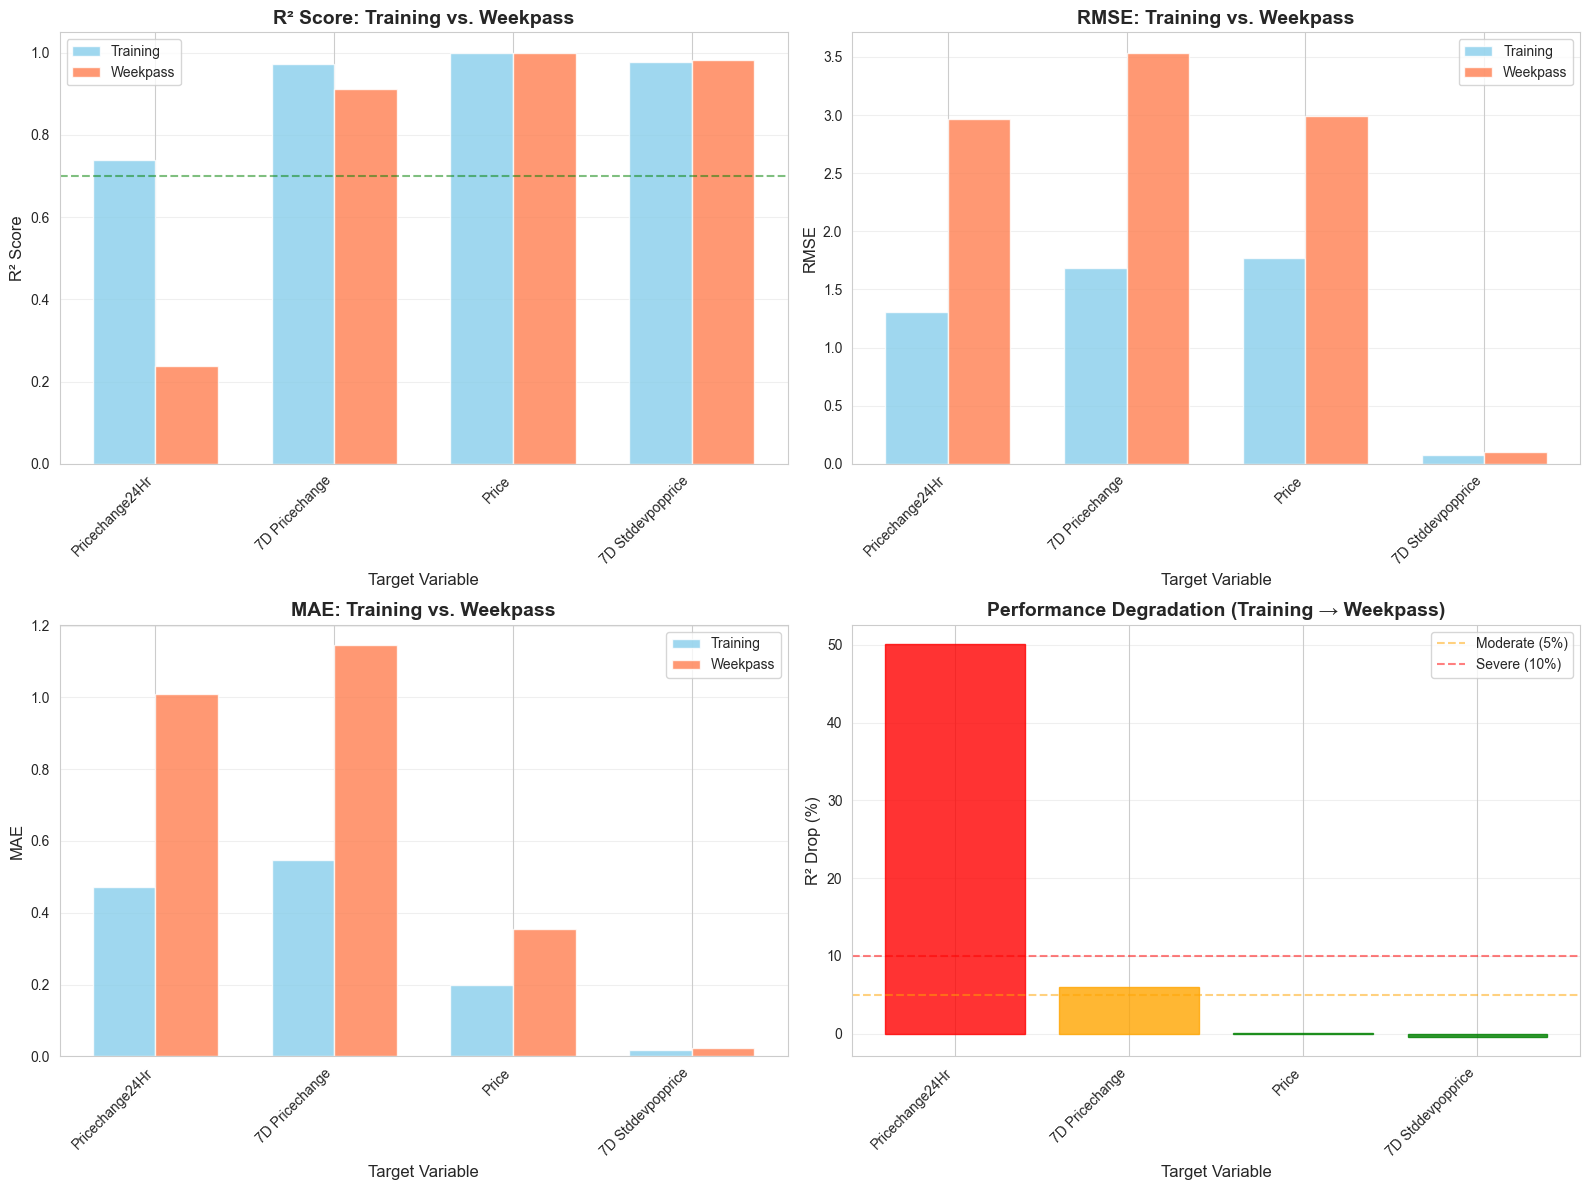

Visualizations saved to: model_performance_comparison.png


In [17]:
# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

metrics = ['r2', 'rmse', 'mae']
metric_names = {
    'r2': 'R² Score',
    'rmse': 'RMSE',
    'mae': 'MAE'
}

# Prepare data for plotting
comparison_data = []
for target in TARGET_VARIABLES:
    if target in results['training'] and results['training'][target] and \
       target in results['weekpass'] and results['weekpass'][target]:
        for metric in metrics:
            comparison_data.append({
                'Target': target.replace('_', ' ').title(),
                'Metric': metric_names[metric],
                'Training': results['training'][target][metric],
                'Weekpass': results['weekpass'][target][metric]
            })

df_comparison = pd.DataFrame(comparison_data)

# Plot 1: R² Comparison
ax = axes[0]
if 'R² Score' in df_comparison['Metric'].values:
    df_r2 = df_comparison[df_comparison['Metric'] == 'R² Score']
    x = np.arange(len(df_r2))
    width = 0.35
    ax.bar(x - width/2, df_r2['Training'], width, label='Training', alpha=0.8, color='skyblue')
    ax.bar(x + width/2, df_r2['Weekpass'], width, label='Weekpass', alpha=0.8, color='coral')
    ax.set_xlabel('Target Variable', fontsize=12)
    ax.set_ylabel('R² Score', fontsize=12)
    ax.set_title('R² Score: Training vs. Weekpass', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(df_r2['Target'], rotation=45, ha='right')
    ax.legend()
    ax.axhline(y=0.7, color='green', linestyle='--', alpha=0.5, label='Good threshold')
    ax.grid(axis='y', alpha=0.3)

# Plot 2: RMSE Comparison
ax = axes[1]
if 'RMSE' in df_comparison['Metric'].values:
    df_rmse = df_comparison[df_comparison['Metric'] == 'RMSE']
    x = np.arange(len(df_rmse))
    width = 0.35
    ax.bar(x - width/2, df_rmse['Training'], width, label='Training', alpha=0.8, color='skyblue')
    ax.bar(x + width/2, df_rmse['Weekpass'], width, label='Weekpass', alpha=0.8, color='coral')
    ax.set_xlabel('Target Variable', fontsize=12)
    ax.set_ylabel('RMSE', fontsize=12)
    ax.set_title('RMSE: Training vs. Weekpass', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(df_rmse['Target'], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

# Plot 3: MAE Comparison
ax = axes[2]
if 'MAE' in df_comparison['Metric'].values:
    df_mae = df_comparison[df_comparison['Metric'] == 'MAE']
    x = np.arange(len(df_mae))
    width = 0.35
    ax.bar(x - width/2, df_mae['Training'], width, label='Training', alpha=0.8, color='skyblue')
    ax.bar(x + width/2, df_mae['Weekpass'], width, label='Weekpass', alpha=0.8, color='coral')
    ax.set_xlabel('Target Variable', fontsize=12)
    ax.set_ylabel('MAE', fontsize=12)
    ax.set_title('MAE: Training vs. Weekpass', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(df_mae['Target'], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

# Plot 4: Performance Drop
ax = axes[3]
performance_drops = []
for target in TARGET_VARIABLES:
    if target in results['training'] and results['training'][target] and \
       target in results['weekpass'] and results['weekpass'][target]:
        drop = (results['training'][target]['r2'] - results['weekpass'][target]['r2']) * 100
        performance_drops.append({
            'Target': target.replace('_', ' ').title(),
            'R² Drop (%)': drop
        })

if performance_drops:
    df_drops = pd.DataFrame(performance_drops)
    bars = ax.bar(df_drops['Target'], df_drops['R² Drop (%)'], alpha=0.8, color='lightcoral')
    
    # Color bars based on severity
    for i, bar in enumerate(bars):
        drop_val = df_drops['R² Drop (%)'].iloc[i]
        if drop_val > 10:
            bar.set_color('red')
        elif drop_val > 5:
            bar.set_color('orange')
        else:
            bar.set_color('green')
    
    ax.set_xlabel('Target Variable', fontsize=12)
    ax.set_ylabel('R² Drop (%)', fontsize=12)
    ax.set_title('Performance Degradation (Training → Weekpass)', fontsize=14, fontweight='bold')
    ax.axhline(y=5, color='orange', linestyle='--', alpha=0.5, label='Moderate (5%)')
    ax.axhline(y=10, color='red', linestyle='--', alpha=0.5, label='Severe (10%)')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualizations saved to: model_performance_comparison.png")

## Prediction vs. Actual Plots

Create scatter plots showing predicted vs. actual values for each model.

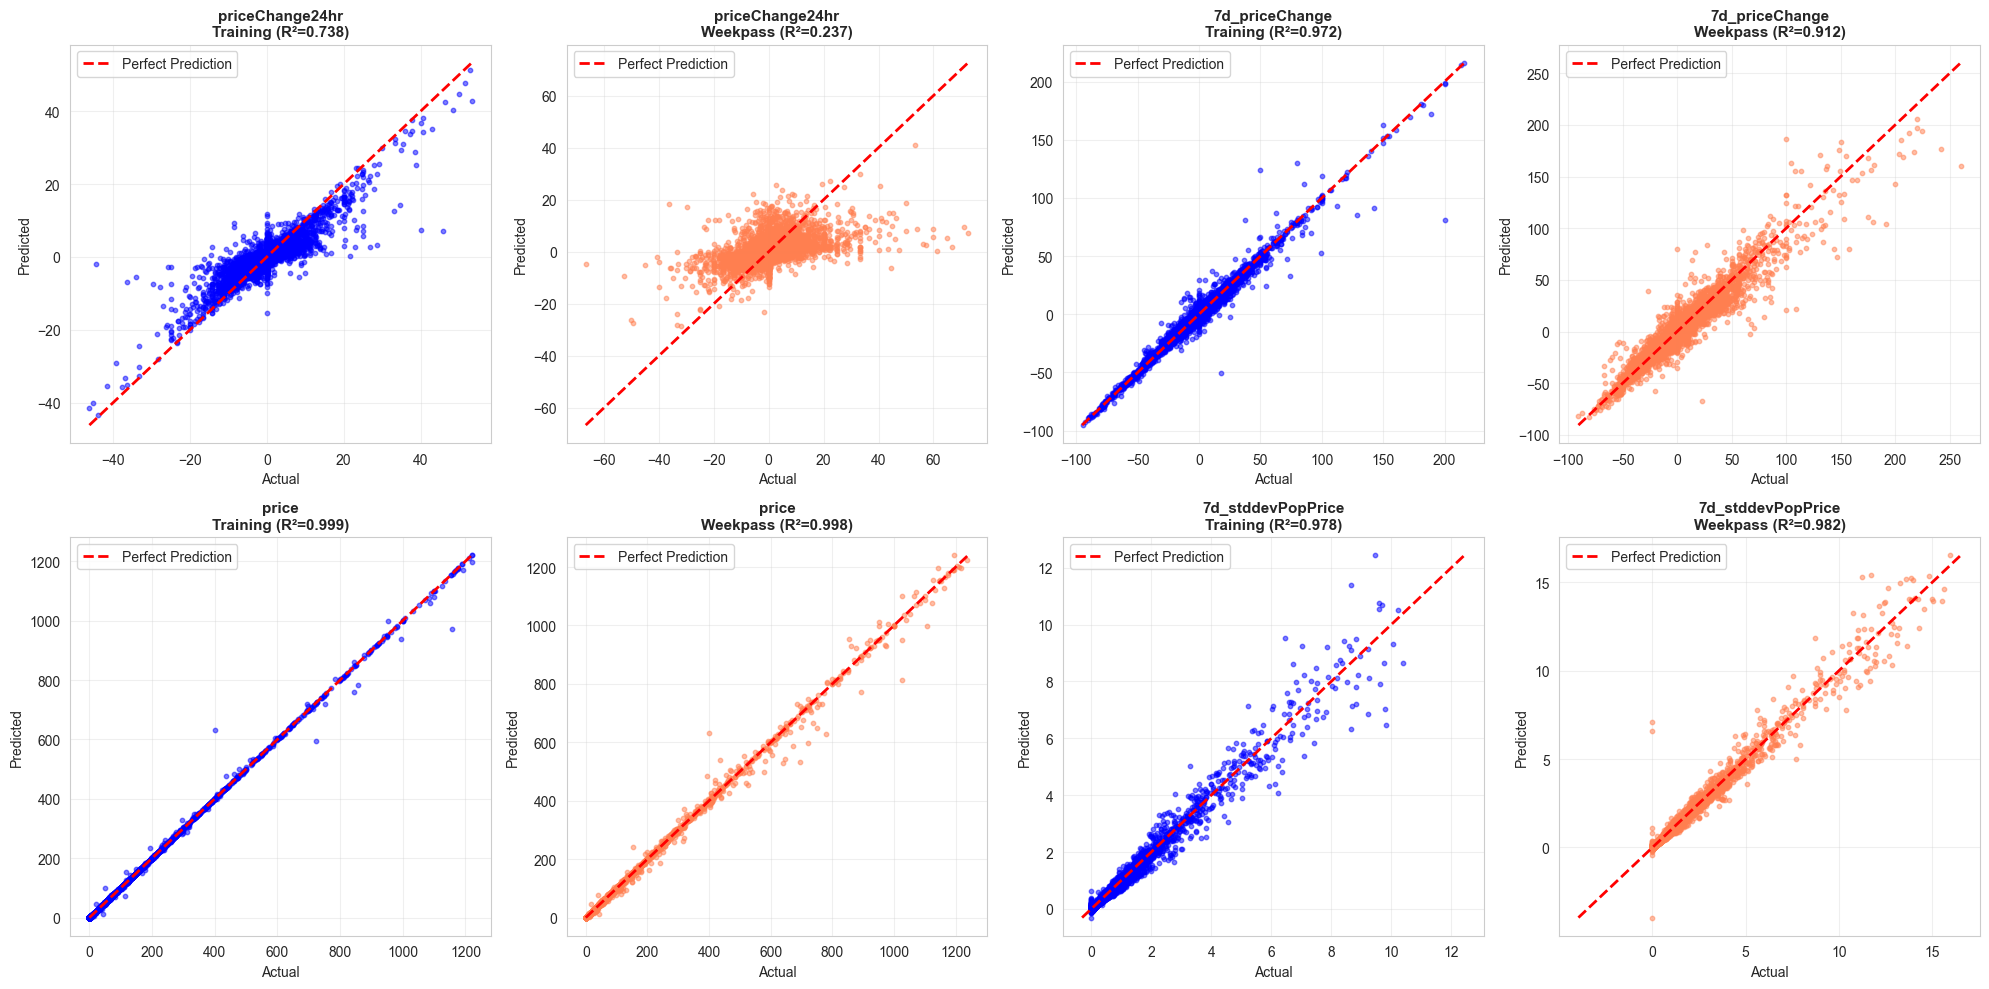

Predictions plot saved to: prediction_vs_actual.png


In [19]:
# Create prediction vs actual plots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

plot_idx = 0
for target in TARGET_VARIABLES:
    if target not in results['training'] or not results['training'][target]:
        continue
    
    # Training data plot
    ax = axes[plot_idx]
    train_res = results['training'][target]
    ax.scatter(train_res['y_true'], train_res['y_pred'], alpha=0.5, s=10, color='blue')
    
    # Add perfect prediction line
    min_val = min(train_res['y_true'].min(), train_res['y_pred'].min())
    max_val = max(train_res['y_true'].max(), train_res['y_pred'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    ax.set_xlabel('Actual', fontsize=10)
    ax.set_ylabel('Predicted', fontsize=10)
    ax.set_title(f'{target}\nTraining (R²={train_res["r2"]:.3f})', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    
    plot_idx += 1
    
    # Weekpass data plot
    if target in results['weekpass'] and results['weekpass'][target]:
        ax = axes[plot_idx]
        test_res = results['weekpass'][target]
        ax.scatter(test_res['y_true'], test_res['y_pred'], alpha=0.5, s=10, color='coral')
        
        # Add perfect prediction line
        min_val = min(test_res['y_true'].min(), test_res['y_pred'].min())
        max_val = max(test_res['y_true'].max(), test_res['y_pred'].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
        
        ax.set_xlabel('Actual', fontsize=10)
        ax.set_ylabel('Predicted', fontsize=10)
        ax.set_title(f'{target}\nWeekpass (R²={test_res["r2"]:.3f})', fontsize=11, fontweight='bold')
        ax.legend()
        ax.grid(alpha=0.3)
        
        plot_idx += 1

# Hide unused subplots
for idx in range(plot_idx, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('prediction_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()

print("Predictions plot saved to: prediction_vs_actual.png")

## Generate Evidently Reports (Optional)

Generate drift detection and regression performance reports using Evidently AI.

In [ ]:
# Generate Evidently reports for each target variable

#Created with the assisstance of ChatGPT for API error handling
if use_evidently:
    print("\n" + "="*80)
    print("GENERATING EVIDENTLY REPORTS")
    print("="*80)
    
    for target in TARGET_VARIABLES:
        if target not in results['training'] or not results['training'][target]:
            continue
        if target not in results['weekpass'] or not results['weekpass'][target]:
            continue
        
        print(f"\n📊 Generating report for: {target}")
        
        try:
            # Prepare data for Evidently
            train_res = results['training'][target]
            test_res = results['weekpass'][target]
            
            # Get feature data
            X_train, y_train, _, _ = prepare_features(df_training, target)
            X_test, y_test, _, _ = prepare_features(df_weekpass, target)
            
            # Create dataframes with predictions
            train_data = X_train.copy()
            train_data['target'] = train_res['y_true'].values
            train_data['prediction'] = train_res['y_pred']
            
            test_data = X_test.copy()
            test_data['target'] = test_res['y_true'].values
            test_data['prediction'] = test_res['y_pred']
            
            # Sample data if too large (Evidently works better with smaller datasets)
            if len(train_data) > 10000:
                train_data = train_data.sample(10000, random_state=42)
            if len(test_data) > 10000:
                test_data = test_data.sample(10000, random_state=42)
            
            # Create DataDefinition with regression specification
            data_definition = DataDefinition(
                regression=[Regression(target='target', prediction='prediction')]
            )
            
            # Convert to Evidently Datasets
            reference_dataset = Dataset.from_pandas(train_data, data_definition=data_definition)
            current_dataset = Dataset.from_pandas(test_data, data_definition=data_definition)
            
            # Create and run regression report
            regression_report = Report(
                metrics=[
                    RegressionPreset(),
                    DataDriftPreset()
                ]
            )
            
            # Run the report (no column_mapping parameter needed with Dataset API)
            eval_report = regression_report.run(
                reference_data=reference_dataset,
                current_data=current_dataset
            )
            
            # Save report locally
            report_path = f"evidently_report_{target}.html"
            eval_report.save_html(report_path)
            print(f"Report saved: {report_path}")
            
            # Upload to Evidently Cloud
            try:
                ws.add_run(
                    project.id,
                    eval_report,
                    include_data=True,
                    name=f"Trading Card Game {target} - Training vs Weekpass"
                )
                print(f"Uploaded to Evidently Cloud")
            except Exception as e:
                print(f"Failed to upload to cloud: {e}")
            
        except Exception as e:
            print(f"Error generating report: {e}")
            import traceback
            traceback.print_exc()
    
    print("\n" + "="*80)
    print("EVIDENTLY REPORTS COMPLETE")
    print("="*80)
else:
    print("\nSkipping Evidently reports (not configured)")



GENERATING EVIDENTLY REPORTS

📊 Generating report for: priceChange24hr
  ✅ Report saved: evidently_report_priceChange24hr.html
  ✅ Report saved: evidently_report_priceChange24hr.html
  ✅ Uploaded to Evidently Cloud

📊 Generating report for: 7d_priceChange
  ✅ Uploaded to Evidently Cloud

📊 Generating report for: 7d_priceChange
  ✅ Report saved: evidently_report_7d_priceChange.html
  ✅ Report saved: evidently_report_7d_priceChange.html
  ✅ Uploaded to Evidently Cloud

📊 Generating report for: price
  ✅ Uploaded to Evidently Cloud

📊 Generating report for: price
  ✅ Report saved: evidently_report_price.html
  ✅ Report saved: evidently_report_price.html
  ✅ Uploaded to Evidently Cloud

📊 Generating report for: 7d_stddevPopPrice
  ✅ Uploaded to Evidently Cloud

📊 Generating report for: 7d_stddevPopPrice
  ✅ Report saved: evidently_report_7d_stddevPopPrice.html
  ✅ Report saved: evidently_report_7d_stddevPopPrice.html
  ✅ Uploaded to Evidently Cloud

EVIDENTLY REPORTS COMPLETE
  ✅ Uploaded

## Summary and Recommendations

Generate final summary with recommendations based on evaluation results.

In [ ]:
# Generate summary report
print("\n" + "="*80)
print("PERFORMANCE EVALUATION SUMMARY")
print("="*80)

summary = {
    'evaluation_date': pd.Timestamp.now().isoformat(),
    'models_evaluated': len(models_data),
    'results': {}
}

for target in TARGET_VARIABLES:
    if target not in results['training'] or not results['training'][target]:
        continue
    if target not in results['weekpass'] or not results['weekpass'][target]:
        continue
    
    train_res = results['training'][target]
    test_res = results['weekpass'][target]
    
    r2_drop = (train_res['r2'] - test_res['r2']) * 100
    
    # Determine status
    if test_res['r2'] >= 0.7:
        status = "EXCELLENT"
    elif test_res['r2'] >= 0.5:
        status = "GOOD"
    elif test_res['r2'] >= 0.3:
        status = "FAIR"
    else:
        status = "POOR"
    
    # Determine generalization
    if r2_drop <= 5:
        generalization = "Excellent generalization"
    elif r2_drop <= 10:
        generalization = "Moderate degradation"
    else:
        generalization = "Significant overfitting"
    
    summary['results'][target] = {
        'model_type': models_data[target]['model_type'],
        'training_r2': train_res['r2'],
        'weekpass_r2': test_res['r2'],
        'r2_drop_pct': r2_drop,
        'training_rmse': train_res['rmse'],
        'weekpass_rmse': test_res['rmse'],
        'status': status,
        'generalization': generalization
    }
    
    print(f"\n{target.upper()}")
    print("-" * 60)
    print(f"  Model Type:         {models_data[target]['model_type'].upper()}")
    print(f"  Training R²:        {train_res['r2']:.4f}")
    print(f"  Weekpass R²:        {test_res['r2']:.4f}")
    print(f"  Performance Drop:   {r2_drop:.2f}%")
    print(f"  Status:             {status}")
    print(f"  Generalization:     {generalization}")
    
    # Recommendations
    print(f"\n  Recommendations:")
    if test_res['r2'] < 0.5:
        print(f"    • Model performance is below acceptable threshold")
        print(f"    • Consider retraining with more data or different features")
    if r2_drop > 10:
        print(f"    • Model shows signs of overfitting")
        print(f"    • Consider regularization or reducing model complexity")
    if test_res['r2'] >= 0.7 and r2_drop <= 5:
        print(f"    • Model is performing well and generalizing effectively")
        print(f"    • Ready for production use")

# Save summary to JSON
with open('model_evaluation_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\n" + "="*80)
print("Summary saved to: model_evaluation_summary.json")
print("="*80)

## Conclusion

This evaluation provides a comprehensive comparison of model performance between training and weekpass test data. Key insights:

1. **Performance Metrics**: R², RMSE, and MAE for each model on both datasets
2. **Generalization Assessment**: How well models transfer to new data
3. **Drift Detection**: Potential data distribution changes between datasets
4. **Recommendations**: Actionable insights for model improvement

Review the generated visualizations and Evidently reports for detailed analysis.